# 1. Data Load

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 
from pickle import dump

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

In [3]:
path = "./Dataset/"

data = pd.read_csv(path+"train.csv")

# original data -> data
data

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,0,1.00,5.00,5.00,5.00,1.00,4.00,5.00,5.00,1.00,...,1.00,20,2.00,12.00,4.00,2.00,1.00,4.00,2.00,1
1,1,4.00,4.00,4.00,4.00,4.00,5.00,4.00,4.00,3.00,...,1.00,49,1.00,2.00,1.00,1.00,2.00,4.00,2.00,1
2,2,4.00,5.00,5.00,4.00,3.00,5.00,5.00,5.00,4.00,...,2.00,43,1.00,2.00,2.00,2.00,3.00,4.00,2.00,1
3,3,4.00,4.00,4.00,2.00,4.00,3.00,3.00,5.00,3.00,...,1.00,17,2.00,1.00,1.00,2.00,1.00,2.00,2.00,1
4,4,4.00,4.00,4.00,4.00,3.00,3.00,4.00,2.00,3.00,...,2.00,18,2.00,12.00,1.00,2.00,1.00,1.00,2.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2.00,5.00,4.00,3.00,3.00,4.00,4.00,4.00,3.00,...,1.00,17,1.00,1.00,3.00,2.00,1.00,3.00,2.00,0
14996,14996,5.00,4.00,5.00,4.00,4.00,5.00,5.00,4.00,4.00,...,2.00,45,1.00,3.00,1.00,1.00,2.00,3.00,2.00,1
14997,14997,4.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,...,1.00,20,1.00,1.00,2.00,1.00,1.00,3.00,1.00,1
14998,14998,5.00,5.00,4.00,5.00,5.00,5.00,5.00,1.00,5.00,...,1.00,29,1.00,12.00,4.00,2.00,2.00,2.00,1.00,0


# 2. EDA 

15,000 rows × 70 columns

- feature (1)
    - index 
- Categorical variable (63)
    - country : 137 values, not valanced 
    - education : 4 values 
    - urban : 4 values, but start with 0 
    - gender : 3 
    - engnat : 2 
    - hand : 3 
    - religion : 12 
    - orientation : 5
    - voted : 2
    - married : 3
    - ASD : 2 
    - Q(26) : 5 values
        - 1=Disagree, 2=Slightly disagree, 3=Neutral, 4=Slightly agree, 5=Agree
    - TIPI(10) : 5 values 
        - items were rated "I see myself as:" _____ such that Extraverted, enthusiastic...
    - VCL(16) : 2 values (0 or 1) 
        - no more need for preprocessing
- Numerical variable (5)
    - introelapse : 1315 values 
    - testelapse : 684 values 
    - surveyelapse : 712 values
    - age : 76 values, but maybe outlier...
    - familysize : 20 values, but maybe outlier... 
- Y variable (1)
    - nerdiness 
        - binary classification 
        - 1:8303, 0:6697

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         15000 non-null  int64  
 1   Q1            14959 non-null  float64
 2   Q2            14931 non-null  float64
 3   Q3            14950 non-null  float64
 4   Q4            14929 non-null  float64
 5   Q5            14962 non-null  float64
 6   Q6            14952 non-null  float64
 7   Q7            14924 non-null  float64
 8   Q8            14952 non-null  float64
 9   Q9            14944 non-null  float64
 10  Q10           14928 non-null  float64
 11  Q11           14941 non-null  float64
 12  Q12           14933 non-null  float64
 13  Q13           14960 non-null  float64
 14  Q14           14964 non-null  float64
 15  Q15           14955 non-null  float64
 16  Q16           14967 non-null  float64
 17  Q17           14963 non-null  float64
 18  Q18           14937 non-nu

<AxesSubplot:>

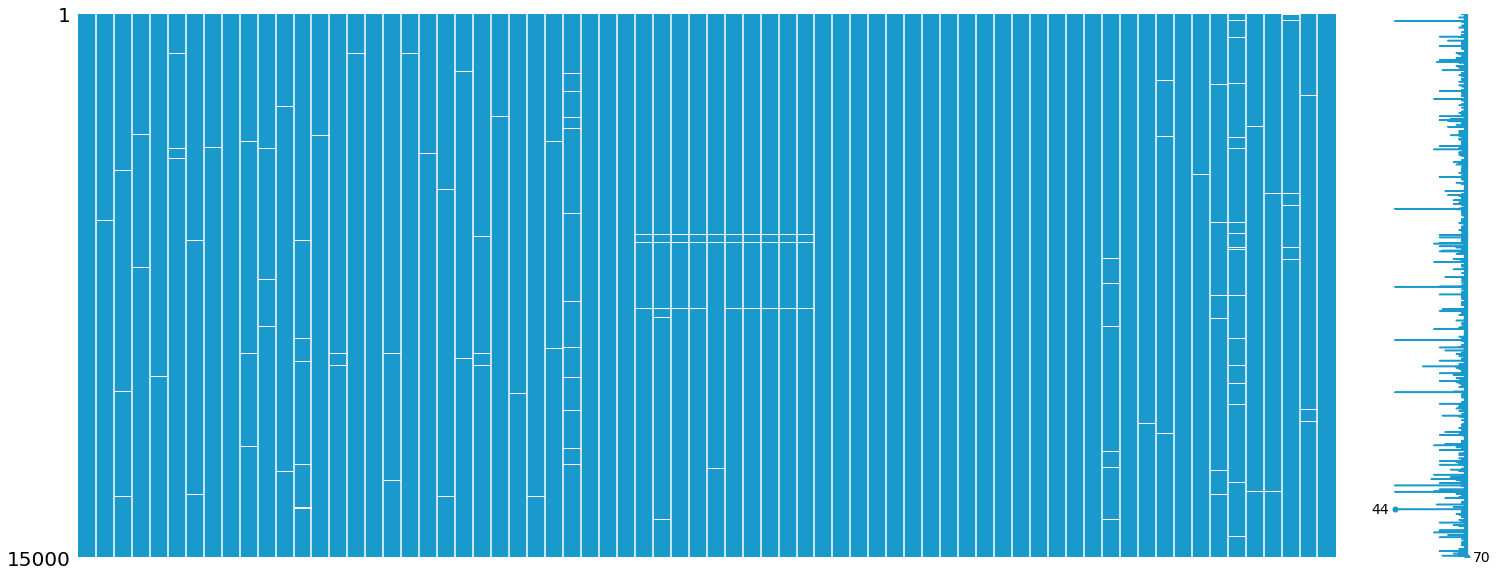

In [4]:
# missing value check
msno.matrix(data.iloc[:, :], color=(0.1, 0.6, 0.8))

# 3. Preprocessing
data -> processed_data (**15,000 x 70 -> 15,000 x 50**)

Basic 
- **Drop unnecessary features** 
    - index, country(...)
- **Handling missing values (...)**
    - **fillna 0**
        - education, gender, hand, religion, orientation, voted, married, ASD
        - 무응답은 0으로 채우기 (urban은 이미 0부터 시작) 
    - **imputation : simple method**
        
Question (Q, TIPI, VCL)
- TIPI scoring to 'O', 'C', 'E', 'A', 'N' 
- VCL scoring (he words at **VCL6, VCL9, and VCL12** are not real words and can be used as a validity check)

    
Numerical
- **Log Transformation**
    - 3 elapse cols (intro, test, survey)
- **Ranging**
    - 'age' to 10 category (0~10/10~20..90~100)
- **Handling outlier**
    - 'familysize' to make np.Nan and imputate


In [4]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# Feature drop 
#'index', 'country'
processed_data = data.drop(['index', 'country'], axis=1).copy()

In [5]:
# Handling missing values with simple imputator
# 'education', 'gender', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer

fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD', 'nerdiness']
transformer = SimpleImputer()
processed_data[fill_cols] = transformer.fit_transform(processed_data[fill_cols])
processed_data[fill_cols].describe()

,education,gender,engnat,hand,religion,orientation,voted,married,ASD,nerdiness
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,2.31,1.70,1.35,1.19,4.10,1.85,1.63,1.18,1.94,0.55
std,0.92,0.55,0.47,0.48,3.40,1.21,0.48,0.46,0.24,0.50
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
25%,2.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,2.00,0.00
50%,2.00,2.00,1.00,1.00,2.00,1.00,2.00,1.00,2.00,1.00
75%,3.00,2.00,2.00,1.00,6.00,2.00,2.00,1.00,2.00,1.00
max,4.00,3.00,2.00,3.00,12.00,5.00,2.00,3.00,2.00,1.00


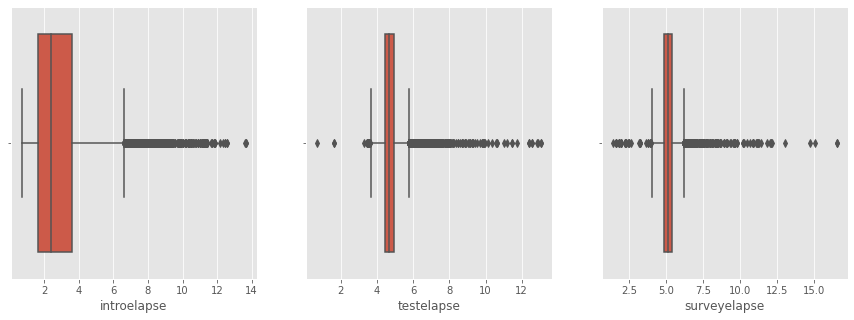

In [6]:
# Log Transformation
# 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    processed_data[c] = np.log1p(processed_data[c])

# for checking 
plt.style.use("ggplot") 
plt.figure(figsize=(15,5))
    
for i in range(len(right_skewed_cols)):
    plt.subplot(1,3,i+1)
    sns.boxplot(x=right_skewed_cols[i], data=processed_data)

In [7]:
# Ranging and ordinary encoding 
# 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
processed_data['age'] = pd.cut(processed_data['age'], bins=bins, labels=labels, right=False)

oe = OrdinalEncoder()
processed_data['age'] = oe.fit_transform(processed_data['age'].values.reshape(-1,1))
processed_data['age'].value_counts()

0.00    6824
1.00    5161
2.00    1493
3.00     822
4.00     459
5.00     202
6.00      28
9.00       7
7.00       3
8.00       1
Name: age, dtype: int64

count   15000.00
mean        2.30
std         0.84
min         1.00
25%         2.00
50%         2.00
75%         3.00
max         4.00
Name: familysize, dtype: float64


<AxesSubplot:xlabel='familysize'>

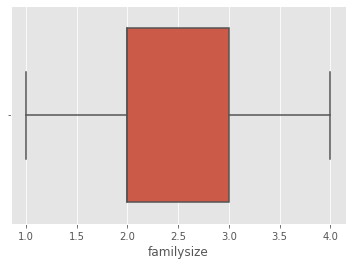

In [8]:
# Handling outlier and iterative imputation
# 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
processed_data[['familysize', 'nerdiness']] = transformer.fit_transform(processed_data[['familysize', 'nerdiness']])
print(processed_data['familysize'].describe())
sns.boxplot(x='familysize', data=processed_data)

<AxesSubplot:>

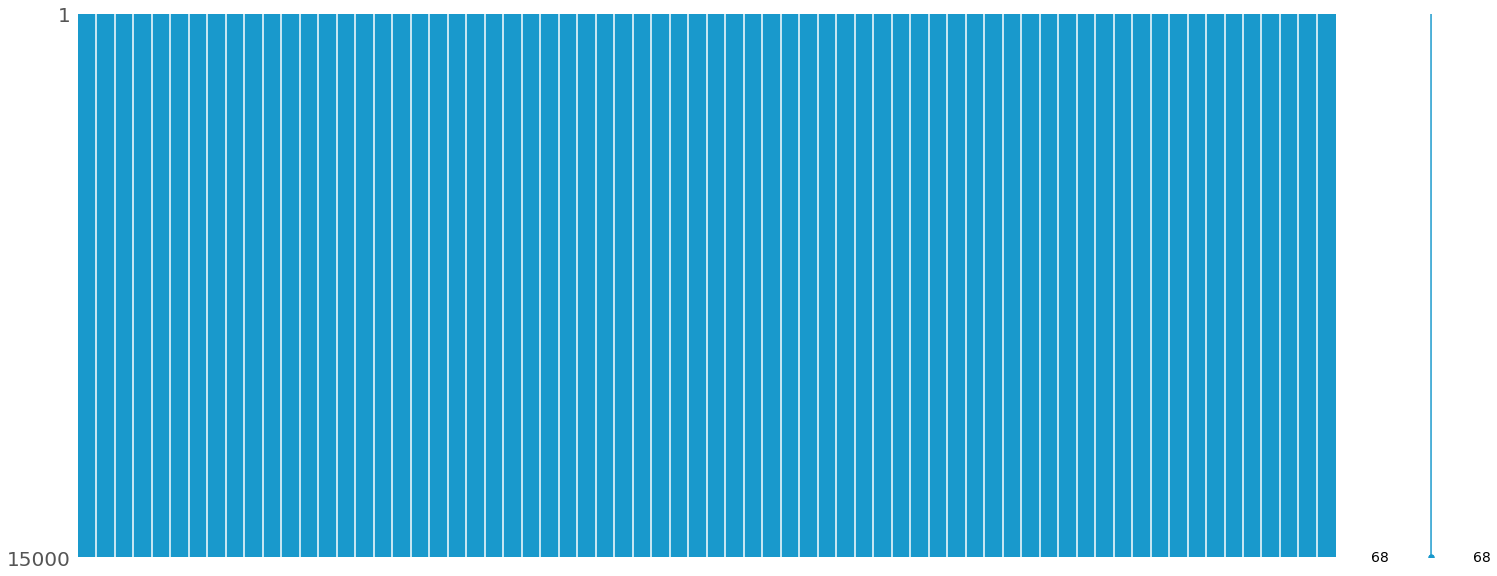

In [9]:
# finish handling missing values! 
from sklearn.impute import SimpleImputer

npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
q_cols = [npas_cols, tipi_cols, vcl_cols]

for col in q_cols : 
    transformer = SimpleImputer()
    processed_data[col] = transformer.fit_transform(processed_data[col])
    
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

the Nerdy Personality Attributes Scale

Your score was 30. Scores range from a low of 30 to a high of 70. The exact average score is 50. People who score higher on the NPAS are more likely to identify as nerds. Below is a graph of what percent of people say yes when asked the question "Are you a nerd?" based on what their NPAS score was.

http://openpsychometrics.org/tests/NPAS/development/

In [10]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

processed_data = score_mach(processed_data)
processed_data['Mach']

0       3.05
1       3.10
2       3.00
3       2.95
4       2.95
        ... 
14995   3.15
14996   2.80
14997   3.00
14998   2.65
14999   2.95
Name: Mach, Length: 15000, dtype: float64

TIPI scale scoring (“R” denotes reverse-scored items):



- Extraversion: 1, 6R; 

- Agreeableness: 2R, 7; 

- Conscientiousness; 3, 8R; 

- Emotional Stability: 4R, 9;

- Openness to Experiences: 5, 10R.

coring the TIPI

1. Recode the reverse-scored items (i.e., recode a 7 with a 1, a 6 with a 2, a 5 with a 3, etc.). The reverse scored items are 2, 4, 6, 8, & 10.

2. Take the AVERAGE of the two items (the standard item and the recoded reverse-scored item) that make up each scale.

Example using the Extraversion scale: A participant has scores of 5 on item 1 (Extraverted, enthusiastic) and and 2 on item 6 (Reserved, quiet). First, recode the reverse-scored item (i.e., item 6), replacing the 2 with a 6. Second, take the average of the score for item 1 and the (recoded) score for item 6. So the TIPI Extraversion scale score would be: (5 + 6)/2 = 5.5

https://gosling.psy.utexas.edu/scales-weve-developed/ten-item-personality-measure-tipi/

In [11]:
def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

processed_data = score_tipi(processed_data)
processed_data[['E', 'A', 'C', 'N', 'O']]

,E,A,C,N,O
0,3.50,5.00,5.00,6.00,4.00
1,5.00,5.50,5.00,2.50,4.50
2,2.00,4.50,3.50,6.00,5.50
3,4.00,4.50,3.50,3.50,5.00
4,3.50,4.00,4.00,3.50,5.00
...,...,...,...,...,...
14995,2.50,4.50,4.50,4.00,4.00
14996,4.00,5.00,5.50,2.50,5.00
14997,2.00,4.00,3.50,2.00,4.00
14998,2.00,6.00,3.50,2.50,5.50


VCL scale scoring

The following items were presented as a check-list and subjects were instructed "In the grid below, check all the words whose definitions you are sure you know":

A value of 1 is checked, 0 means unchecked. The words at VCL6, VCL9, and VCL12 are not real words and can be used as a validity check.

https://www.kaggle.com/datasets/lucasgreenwell/nerdy-personality-attributes-scale-responses

In [12]:
def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

processed_data = score_vcl(processed_data)
processed_data[['VCL_score', 'VCL_faker']]

,VCL_score,VCL_faker
0,8.00,0.00
1,11.00,0.00
2,11.00,0.00
3,9.00,0.00
4,8.00,0.00
...,...,...
14995,10.00,1.00
14996,8.00,0.00
14997,9.00,0.00
14998,11.00,1.00


# 4. Data Split 
split data as train/valid

In [13]:
# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, input data = input_data 
input_data = processed_data.copy()
input_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,ASD,nerdiness,Mach,E,A,C,N,O,VCL_score,VCL_faker
0,1.00,5.00,1.00,1.00,1.00,4.00,1.00,5.00,5.00,3.00,...,2.00,1.00,3.05,3.50,5.00,5.00,6.00,4.00,8.00,0.00
1,4.00,4.00,2.00,2.00,4.00,5.00,2.00,4.00,3.00,3.00,...,2.00,1.00,3.10,5.00,5.50,5.00,2.50,4.50,11.00,0.00
2,4.00,5.00,1.00,2.00,3.00,5.00,1.00,5.00,2.00,2.00,...,2.00,1.00,3.00,2.00,4.50,3.50,6.00,5.50,11.00,0.00
3,4.00,4.00,2.00,4.00,4.00,3.00,3.00,5.00,3.00,2.00,...,2.00,1.00,2.95,4.00,4.50,3.50,3.50,5.00,9.00,0.00
4,4.00,4.00,2.00,2.00,3.00,3.00,2.00,2.00,3.00,2.00,...,2.00,0.00,2.95,3.50,4.00,4.00,3.50,5.00,8.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.00,5.00,2.00,3.00,3.00,4.00,2.00,4.00,3.00,2.00,...,2.00,0.00,3.15,2.50,4.50,4.50,4.00,4.00,10.00,1.00
14996,5.00,4.00,1.00,2.00,4.00,5.00,1.00,4.00,2.00,1.00,...,2.00,1.00,2.80,4.00,5.00,5.50,2.50,5.00,8.00,0.00
14997,4.00,5.00,1.00,1.00,5.00,5.00,1.00,5.00,2.00,1.00,...,1.00,1.00,3.00,2.00,4.00,3.50,2.00,4.00,9.00,0.00
14998,5.00,5.00,2.00,1.00,5.00,5.00,1.00,1.00,1.00,1.00,...,1.00,0.00,2.65,2.00,6.00,3.50,2.50,5.50,11.00,1.00


In [14]:
input_data_y = input_data['nerdiness'].copy()
input_data_X = input_data.drop(['nerdiness'], axis=1)

In [15]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# train/ test data 로 split 
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 7,
    shuffle=True
)

# 5. Neural Network 

https://dacon.io/competitions/official/235647/codeshare/1812?page=1&dtype=vote

In [16]:
import random
from datetime import datetime

import torch

from sklearn.model_selection import StratifiedKFold
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, classification_report

**Dataset of PyTorch**
PyTorch에서 사용되는 Dataset은 학습에 필요한 데이터 sample을 정제하고 label을 저장하는 기능을 제공함  
Dataset class에는 초기화 메서드(__init__), 호출 메서드(__getitem__), 길이 반환 메서드(__len__)를 재정의하여 활용함 

**DataLoader of PyTorch**
PyTorch에서 사용되는 DataLoader는 데이터 세트(Dataset)에 저장된 데이터를 어떠한 방식으로 불러와 활용할지 정의함  
배치 크기(Batch Size), 데이터 순서 변경(Shuffle), 데이터 로드 프로세스 수(num_workers) 기능 제공  
- 전체 데이터 세트에 대해 배치 크기 만큼 샘플을 나누고 모든 배치를 대상으로 학습을 완료하면 한 번의 epoch 완료 
    - 1,000개의 데이터 샘플에 대해 100 batch size를 지정하면 10번의 batch 완료 = 1 epoch 
- Shuffle을 통해 데이터의 순서로 학습되는 것을 방지함 

https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

https://076923.github.io/posts/Python-pytorch-12/

In [17]:
N_REPEAT = 5
N_SKFOLD = 7
EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.05
LOADER_PARAM = {
    'batch_size': BATCH_SIZE,
    'num_workers': 4,
    'pin_memory': True
}

In [18]:
# Define Custom DataLoaders
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

    
train_data = TrainData(torch.FloatTensor(train_X.to_numpy()), torch.FloatTensor(train_y.to_numpy()))
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

test_data = TestData(torch.FloatTensor(test_X.to_numpy()))
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE)

In [19]:
# Layer dim 
n_input_dim = train_X.shape[1]
n_hidden1 = 294
n_hidden2 = 30
n_output_dim = 1

class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output_dim) 
        
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
    def forward(self, inputs):
        x = self.leakyrelu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.leakyrelu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [21]:
model = BinaryClassification()
model.to(device)
print(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=49, out_features=294, bias=True)
  (layer_2): Linear(in_features=294, out_features=30, bias=True)
  (layer_out): Linear(in_features=30, out_features=1, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(294, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [22]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

train_loss = []
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        train_loss.append(epoch_loss)

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_dataloader):.5f} | Acc: {epoch_acc/len(train_dataloader):.3f}')

Epoch 001: | Loss: 0.57207 | Acc: 70.426
Epoch 002: | Loss: 0.55911 | Acc: 71.191
Epoch 003: | Loss: 0.55778 | Acc: 71.133
Epoch 004: | Loss: 0.55979 | Acc: 71.080
Epoch 005: | Loss: 0.55541 | Acc: 71.543
Epoch 006: | Loss: 0.55850 | Acc: 71.426
Epoch 007: | Loss: 0.55700 | Acc: 71.431
Epoch 008: | Loss: 0.55421 | Acc: 71.771
Epoch 009: | Loss: 0.55808 | Acc: 71.122
Epoch 010: | Loss: 0.55262 | Acc: 71.878
Epoch 011: | Loss: 0.55344 | Acc: 71.755
Epoch 012: | Loss: 0.55865 | Acc: 71.527
Epoch 013: | Loss: 0.55363 | Acc: 71.479
Epoch 014: | Loss: 0.55556 | Acc: 71.681
Epoch 015: | Loss: 0.55402 | Acc: 71.681
Epoch 016: | Loss: 0.55508 | Acc: 71.473
Epoch 017: | Loss: 0.55550 | Acc: 71.830
Epoch 018: | Loss: 0.55580 | Acc: 71.314
Epoch 019: | Loss: 0.55560 | Acc: 71.543
Epoch 020: | Loss: 0.55565 | Acc: 71.617
Epoch 021: | Loss: 0.55001 | Acc: 72.112
Epoch 022: | Loss: 0.55796 | Acc: 71.234
Epoch 023: | Loss: 0.55155 | Acc: 71.793
Epoch 024: | Loss: 0.55389 | Acc: 72.149
Epoch 025: | Los

Epoch 201: | Loss: 0.51279 | Acc: 74.452
Epoch 202: | Loss: 0.51843 | Acc: 74.043
Epoch 203: | Loss: 0.52311 | Acc: 74.335
Epoch 204: | Loss: 0.51495 | Acc: 74.330
Epoch 205: | Loss: 0.51500 | Acc: 74.293
Epoch 206: | Loss: 0.51103 | Acc: 74.638
Epoch 207: | Loss: 0.51156 | Acc: 74.904
Epoch 208: | Loss: 0.51522 | Acc: 74.511
Epoch 209: | Loss: 0.51616 | Acc: 74.543
Epoch 210: | Loss: 0.51397 | Acc: 74.277
Epoch 211: | Loss: 0.51747 | Acc: 74.468
Epoch 212: | Loss: 0.51612 | Acc: 74.452
Epoch 213: | Loss: 0.51101 | Acc: 73.968
Epoch 214: | Loss: 0.51133 | Acc: 74.553
Epoch 215: | Loss: 0.51853 | Acc: 74.234
Epoch 216: | Loss: 0.51563 | Acc: 74.250
Epoch 217: | Loss: 0.51212 | Acc: 74.346
Epoch 218: | Loss: 0.51604 | Acc: 74.367
Epoch 219: | Loss: 0.51415 | Acc: 74.559
Epoch 220: | Loss: 0.51658 | Acc: 74.346
Epoch 221: | Loss: 0.51469 | Acc: 74.378
Epoch 222: | Loss: 0.51307 | Acc: 74.521
Epoch 223: | Loss: 0.51304 | Acc: 74.559
Epoch 224: | Loss: 0.51327 | Acc: 74.606
Epoch 225: | Los

Epoch 401: | Loss: 0.47110 | Acc: 77.181
Epoch 402: | Loss: 0.47417 | Acc: 76.798
Epoch 403: | Loss: 0.47484 | Acc: 77.090
Epoch 404: | Loss: 0.47401 | Acc: 76.739
Epoch 405: | Loss: 0.47504 | Acc: 76.787
Epoch 406: | Loss: 0.47199 | Acc: 77.005
Epoch 407: | Loss: 0.46882 | Acc: 77.755
Epoch 408: | Loss: 0.47486 | Acc: 76.771
Epoch 409: | Loss: 0.47049 | Acc: 77.170
Epoch 410: | Loss: 0.47273 | Acc: 76.824
Epoch 411: | Loss: 0.47254 | Acc: 76.787
Epoch 412: | Loss: 0.46856 | Acc: 77.160
Epoch 413: | Loss: 0.47092 | Acc: 76.920
Epoch 414: | Loss: 0.46867 | Acc: 77.138
Epoch 415: | Loss: 0.46527 | Acc: 77.484
Epoch 416: | Loss: 0.46746 | Acc: 77.670
Epoch 417: | Loss: 0.46628 | Acc: 77.628
Epoch 418: | Loss: 0.47242 | Acc: 77.059
Epoch 419: | Loss: 0.47585 | Acc: 76.559
Epoch 420: | Loss: 0.47101 | Acc: 77.340
Epoch 421: | Loss: 0.46518 | Acc: 77.798
Epoch 422: | Loss: 0.46618 | Acc: 77.069
Epoch 423: | Loss: 0.46949 | Acc: 77.351
Epoch 424: | Loss: 0.46942 | Acc: 77.239
Epoch 425: | Los

Epoch 601: | Loss: 0.44120 | Acc: 78.872
Epoch 602: | Loss: 0.44748 | Acc: 78.532
Epoch 603: | Loss: 0.43635 | Acc: 79.122
Epoch 604: | Loss: 0.44056 | Acc: 79.128
Epoch 605: | Loss: 0.44153 | Acc: 79.128
Epoch 606: | Loss: 0.43775 | Acc: 79.500
Epoch 607: | Loss: 0.43801 | Acc: 79.457
Epoch 608: | Loss: 0.43898 | Acc: 78.947
Epoch 609: | Loss: 0.44591 | Acc: 78.851
Epoch 610: | Loss: 0.44829 | Acc: 78.872
Epoch 611: | Loss: 0.44294 | Acc: 78.957
Epoch 612: | Loss: 0.44990 | Acc: 78.473
Epoch 613: | Loss: 0.43834 | Acc: 79.122
Epoch 614: | Loss: 0.43956 | Acc: 78.856
Epoch 615: | Loss: 0.44904 | Acc: 78.516
Epoch 616: | Loss: 0.44116 | Acc: 79.043
Epoch 617: | Loss: 0.44154 | Acc: 79.133
Epoch 618: | Loss: 0.43873 | Acc: 79.516
Epoch 619: | Loss: 0.43866 | Acc: 79.495
Epoch 620: | Loss: 0.44039 | Acc: 78.777
Epoch 621: | Loss: 0.44556 | Acc: 78.968
Epoch 622: | Loss: 0.43765 | Acc: 79.122
Epoch 623: | Loss: 0.43449 | Acc: 79.548
Epoch 624: | Loss: 0.44233 | Acc: 79.154
Epoch 625: | Los

Epoch 801: | Loss: 0.41236 | Acc: 80.915
Epoch 802: | Loss: 0.41049 | Acc: 80.867
Epoch 803: | Loss: 0.41450 | Acc: 80.559
Epoch 804: | Loss: 0.41547 | Acc: 80.431
Epoch 805: | Loss: 0.41817 | Acc: 80.261
Epoch 806: | Loss: 0.40993 | Acc: 81.250
Epoch 807: | Loss: 0.40942 | Acc: 80.777
Epoch 808: | Loss: 0.41829 | Acc: 80.628
Epoch 809: | Loss: 0.41438 | Acc: 80.564
Epoch 810: | Loss: 0.41379 | Acc: 81.037
Epoch 811: | Loss: 0.41320 | Acc: 80.952
Epoch 812: | Loss: 0.41817 | Acc: 80.532
Epoch 813: | Loss: 0.41384 | Acc: 80.351
Epoch 814: | Loss: 0.41264 | Acc: 80.691
Epoch 815: | Loss: 0.41305 | Acc: 80.936
Epoch 816: | Loss: 0.41111 | Acc: 80.745
Epoch 817: | Loss: 0.40980 | Acc: 80.867
Epoch 818: | Loss: 0.41539 | Acc: 80.697
Epoch 819: | Loss: 0.40909 | Acc: 80.723
Epoch 820: | Loss: 0.41677 | Acc: 80.537
Epoch 821: | Loss: 0.40805 | Acc: 81.149
Epoch 822: | Loss: 0.41502 | Acc: 80.367
Epoch 823: | Loss: 0.39999 | Acc: 81.101
Epoch 824: | Loss: 0.40596 | Acc: 80.878
Epoch 825: | Los

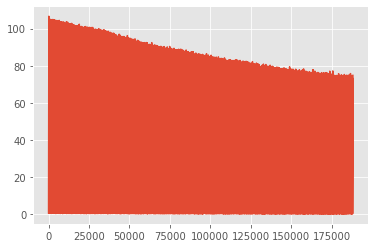

In [539]:
plt.plot(train_loss)
plt.show()

In [55]:
y_pred_list = []
y_prob_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_dataloader:
        X_batch = X_batch.to(device)
        y_test_prob = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_prob)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_prob_list.append(y_test_pred.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_prob_list = [a.squeeze().tolist() for a in y_prob_list]
y_pred_list = np.concatenate(y_pred_list).tolist()
y_prob_list = np.concatenate(y_prob_list).tolist()

In [56]:
roc_auc_score(test_y, y_pred_list)

0.7345661033409543

In [57]:
print(classification_report(test_y, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.73      0.66      0.69      1321
         1.0       0.75      0.81      0.78      1679

    accuracy                           0.74      3000
   macro avg       0.74      0.73      0.74      3000
weighted avg       0.74      0.74      0.74      3000



In [69]:
df_answer = pd.DataFrame([ x for x in zip(y_pred_list, y_prob_list)])
df_answer.tail()

,0,1
2995,1.00,0.99
2996,1.00,0.56
2997,1.00,0.92
2998,0.00,0.48
2999,0.00,0.01


### Test for unseen data

In [74]:
test = torch.tensor(test_X.to_numpy(), dtype=torch.float32)
test

tensor([[ 5.0000,  1.0000,  1.0000,  ...,  6.0000, 13.0000,  0.0000],
        [ 4.0000,  4.0000,  1.0000,  ...,  5.5000, 10.0000,  1.0000],
        [ 4.0000,  5.0000,  1.0000,  ...,  4.0000, 10.0000,  0.0000],
        ...,
        [ 4.0000,  5.0000,  1.0000,  ...,  5.5000, 10.0000,  0.0000],
        [ 4.0000,  4.0000,  1.0000,  ...,  4.5000, 11.0000,  0.0000],
        [ 3.0000,  3.0000,  3.0000,  ...,  5.5000,  9.0000,  1.0000]])

In [83]:
prediction = model(test)
prediction_prob = torch.sigmoid(prediction)
prediction = torch.round(prediction_prob)
prediction = [a.squeeze().tolist() for a in prediction]
prediction_prob = [a.squeeze().tolist() for a in prediction_prob]
prediction

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0

# 6. Saving Models

In [547]:
final_model = model # you should fill out this 

In [548]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M")
filename = 'nn_yesQ_'+filename
filename

'nn_yesQ_0809_18_18'

In [550]:
torch.save(model, path+filename+'.pt')